In [1]:
import torch
from copy import deepcopy

from Lie import inv_SO3, log_SO3, exp_so3, bracket_so3, inv_SE3, log_SE3, exp_se3, bracket_se3
from distributions import get_dist
from ode_solvers import get_ode_solver

from models.modules import FC_vec

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

device = 'cuda:0'

def plot_SE3(transformations, ax=None):
    """
    Visualize a set of SE(3) transformations as coordinate frames.

    Parameters:
        transformations (list of np.ndarray): List of 4x4 SE(3) matrices.
        ax (matplotlib.axes._subplots.Axes3DSubplot, optional): Existing 3D axis to plot on.

    Returns:
        ax: The axis with the plotted transformations.
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-5, 5])

    # Add axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for T in transformations:
        # Extract rotation and translation
        R = T[:3, :3]  # Rotation matrix (3x3)
        t = T[:3, 3]   # Translation vector (3,)

        # Origin of the frame
        origin = t

        # Axes of the frame
        x_axis = R[:, 0]
        y_axis = R[:, 1]
        z_axis = R[:, 2]

        # Plot the axes
        ax.quiver(origin[0], origin[1], origin[2],
                  x_axis[0], x_axis[1], x_axis[2], color='r', label='X' if T is transformations[0] else "")
        ax.quiver(origin[0], origin[1], origin[2],
                  y_axis[0], y_axis[1], y_axis[2], color='g', label='Y' if T is transformations[0] else "")
        ax.quiver(origin[0], origin[1], origin[2],
                  z_axis[0], z_axis[1], z_axis[2], color='b', label='Z' if T is transformations[0] else "")

    ax.legend()
    ax.view_init(elev=20, azim=30)
    return ax

In [13]:
class SE3Flow(torch.nn.Module):
    def __init__(self, vector_field):
        super().__init__()
        self.vector_field = vector_field
        self.init_dist = get_dist({"name": "SO3_uniform_R3_normal"})
        self.ode_solver = get_ode_solver({'name': 'SE3_RK_mk', 'num_steps': 20})

    def forward(self, z, t, x_t):
        # "z" is for conditional variable (deprecated)

        # t: (bs, 1)
        # x_t: (bs, 4, 4)
        inputs = torch.cat([t, x_t.view(-1, 16)], dim=1) # (bs, 17)
        v_t = self.vector_field(inputs)
        return v_t # (bs, 6)

    def get_traj(self, x_0, x_1, t):
        # Get rotations
        R_0 = x_0[:, :3, :3]
        R_1 = x_1[:, :3, :3]

        # Get translations
        p_0 = x_0[:, :3, 3]
        p_1 = x_1[:, :3, 3]

        # Get x_t
        x_t = torch.eye(4).repeat(len(x_1), 1, 1).to(x_1)
        x_t[:, :3, :3] = (R_0 @ exp_so3(t.unsqueeze(2) * log_SO3(inv_SO3(R_0) @ R_1)))
        x_t[:, :3, 3] = p_0 + t * (p_1 - p_0)

        # Get u_t
        u_t = torch.zeros(len(x_1), 6).to(x_1)
        u_t[:, :3] = bracket_so3(log_SO3(inv_SO3(R_0) @ R_1))
        u_t[:, :3] = torch.einsum('bij,bj->bi', R_0, u_t[:, :3])    # Convert w_b to w_s
        u_t[:, 3:] = p_1 - p_0

        return x_t, u_t

    def step(self, x_1, optimizer=None):
        # x_1: (bs, 4, 4)

        # Sample t and x_0
        t = torch.rand(len(x_1), 1).to(x_1.device)
        x_0 = self.init_dist(len(x_1), x_1.device)

        # Get x_t and u_t
        x_t, u_t = self.get_traj(x_0, x_1, t)

        # Forward
        v_t = self(None, t, x_t)

        # Calculate loss
        loss = ((v_t - u_t)**2).mean()

        # Backward
        if optimizer is not None:
            loss.backward()
            optimizer.step()

        # Archive results
        results = {
            f'loss': loss.item(),
        }
        return results

    @torch.no_grad()
    def sample(self, num_samples, device, out_traj=False):
        # Sample initial samples
        x_0 = self.init_dist(num_samples, device)
        
        if out_traj:
            x_1_traj = self.ode_solver(None, x_0, self)
            return x_1_traj[:, -1], x_1_traj
        else:
            x_1_hat = self.ode_solver(None, x_0, self)[:, -1]
            return x_1_hat

C:\Users\21448\AppData\Local\Temp\ipykernel_40364\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


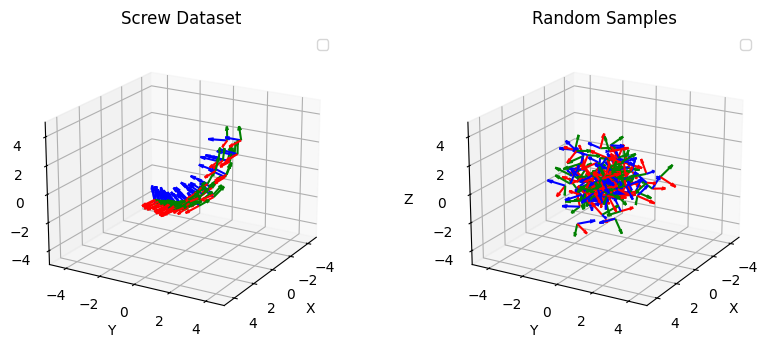

In [14]:
# Toy dataset (screw motion between two SE(3))
T1 = torch.tensor([
    [1, 0, 0, 3],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32).view(1, 4, 4)

T2 = torch.tensor([
    [1, 0, 0, 0],
    [0, 0, -1, 3],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
], dtype=torch.float32).view(1, 4, 4)

V = log_SE3(inv_SE3(T1)@T2)
T_screw = torch.cat([
    T1@exp_se3(
        t/49 *V  + torch.randn_like(V)*0.1
        ) for t in range(50)
    ], dim=0)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('Screw Dataset')
plot_SE3(T_screw, ax=ax1)
r_sampels = get_dist({"name": "SO3_uniform_R3_normal"})(100, 'cpu')
ax2.set_title('Random Samples')
plot_SE3(r_sampels, ax=ax2)
plt.show()

In [15]:
class SE3Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for SE(3) data of shape (N, 4, 4).
    """
    def __init__(self, data):
        """
        Args:
            data (numpy.ndarray or torch.Tensor): Dataset of shape (N, 4, 4).
        """
        if isinstance(data, np.ndarray):
            self.data = torch.tensor(data, dtype=torch.float32)
        elif isinstance(data, torch.Tensor):
            self.data = data.float()
        else:
            raise TypeError("Data must be a numpy array or torch tensor.")

    def __len__(self):
        """Return the number of samples in the dataset."""
        return self.data.shape[0]

    def __getitem__(self, idx):
        """Retrieve a single sample by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            torch.Tensor: A single SE(3) matrix of shape (4, 4).
        """
        return self.data[idx]

In [16]:
ds = SE3Dataset(T_screw)
data_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=10, shuffle=True)

velocity = FC_vec(
    in_chan=17,
    out_chan=6,
    l_hidden=[1024, 1024, ],
    activation=['gelu', 'gelu'],
    out_activation='linear',
)

In [17]:
total_epoch = 10000
model = SE3Flow(velocity)

load_pretraiend = True
if load_pretraiend:
    model.load_state_dict(torch.load('results/SE3flow_model.pth', map_location='cpu'))
model.to(device);

if load_pretraiend:
    total_epoch = 0
else:
    total_epoch = 10000

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1.0e-8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

for epoch in range(total_epoch):
    mean_loss = []
    for x1 in data_loader:
        train_results = model.step(x1.to(device), optimizer)
        mean_loss.append(train_results['loss'])
    mean_loss = sum(mean_loss)/len(mean_loss)
    lr_scheduler.step()
    if epoch % 500 == 0:
        print(f"Epoch: {epoch}, Loss: {mean_loss}")
        
        # save model 
        torch.save(model.state_dict(), 'results/SE3flow_model.pth')


C:\Users\21448\AppData\Local\Temp\ipykernel_40364\2366340696.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('results/SE3flow_model.pth'

### RESULTS

C:\Users\21448\AppData\Local\Temp\ipykernel_40364\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


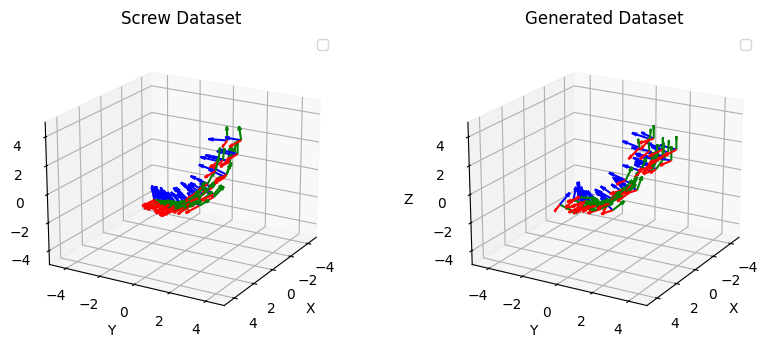

In [18]:
T_gen = model.sample(50, device)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('Screw Dataset')
plot_SE3(T_screw, ax=ax1) 
ax2.set_title('Generated Dataset')
plot_SE3(T_gen.detach().cpu(), ax=ax2)
plt.show()

### ODE

C:\Users\21448\AppData\Local\Temp\ipykernel_40364\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


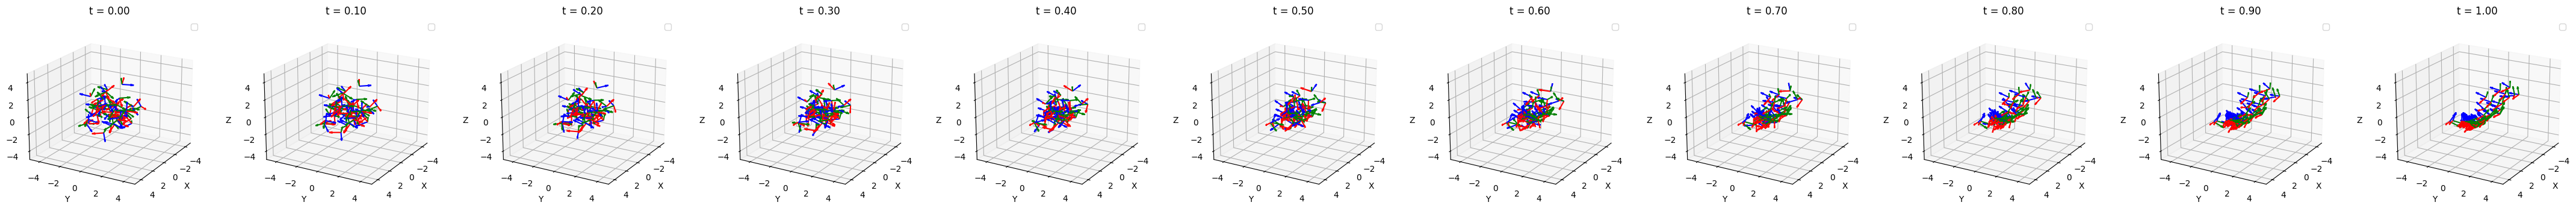

In [30]:
model.ode_solver = get_ode_solver({'name': 'SE3_RK_mk', 'num_steps': 10})
_, T_traj = model.sample(50, device, out_traj=True)
len_ = T_traj.size(1)

fig = plt.figure(figsize=(5 * len_, 4))
for i in range(len_):
    T_gen = T_traj[:, i]
    
    ax = fig.add_subplot(1, len_, i + 1, projection='3d')
    ax.set_title(f"t = {i/(len_-1):.2f}")
    plot_SE3(T_gen.detach().cpu(), ax=ax)

plt.show()

### GIF

In [38]:
from PIL import Image
import io
from utils import display_video

model.ode_solver = get_ode_solver({'name': 'SE3_RK_mk', 'num_steps': 100})
_, T_traj = model.sample(50, device, out_traj=True)
len_ = T_traj.size(1)

video = []
for i in range(len_):
    T_gen = T_traj[:, i]
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title(f"t = {i/(len_-1):.2f}")
    plot_SE3(T_gen.detach().cpu(), ax=ax)

    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer
    plt.close()
    
    video.append(image_array)

C:\Users\21448\AppData\Local\Temp\ipykernel_40364\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


In [39]:
display_video(video, framerate=20)